ChatGPTが大バズリしている昨今です。僕はプロンプトを考えるのが面倒なので（ええ...)あまり使わないのですが、友人が論文を書くのに使っていたり、僕の母親が話し相手に使っていたりするようです。親不孝な息子でごめんなさいという感じもします。
ところで、ChatGPTのような言語生成モデルでしばしば利用されているのが、Transformerと呼ばれるニューラルネットワークの構成です。Transformerでは、Multihead Attentionと呼ばれるレイヤーを入力のトークン列に対し繰り返し適用し複雑なモデルを構成します。このブログでは、その簡略版である1レイヤーのAttention(Multiheadではない)に着目し、これが何をしているのかを勉強し、ついでにコードを書いて動かしてみます。

# 参考にしたもの
- [Formal Algorithms for Transformers](https://arxiv.org/abs/2207.09238)
  - 疑似コードをまとめた論文です。これが一番わかりやすいと思うので、とりあえずこれを見ればいいと思います。他にも[The Illustrated GPT-2](https://jalammar.github.io/illustrated-gpt2/)などを見たのですが、よくわかりませんでした。
- [Shumi-Note Transformer](https://github.com/syuntoku14/Shumi-Note/blob/main/notebooks/NN_transformer.ipynb)
  - これを見て真似しようと思ったのがこの記事のきっかけです。

# トークン列のエンコーディング
Attentionは、入力としてトークンの列が与えられることを

## 最初に列があった
トークン列というのは文字通りトークンからなる列のことです。トークンは有限集合の要素です。実用上はbyte pair encodingにより得られた部分文字列などがこれに該当しますが、とりあえず気にしなくていいです。トークンの集合を$V$とし、$[Nv] := {1, ..., Nv}$と番号付けしておきます。トークン列を$x = x[1: l]$と書きます。また、トークン列の最大の長さを$L$とします。トークンとして連続値や無限集合は扱えないと思いますが、素人なので何か抜け道があるかどうかは知りません。

## トークンからベクトルに
適当な$d_e \times Nv$次元の行列$W_e$を使って、$v$番目のトークンから埋め込み（Token embedding）を $e = W_e[:, v]$により得ます。これは$d_e$次元のベクトルになります。なお、numpy風に$i$番目の行ベクトルを$W[i, :]$、$j$番目の列ベクトルを$W[:, j]$と書いています。この行列$W_e$は勾配降下により学習されるようです。

## ついでに位置もベクトルに
適当な$d_p \times L$次元の行列$W_p$を使って、トークン列中の$l$番目にトークンがあるという情報から、位置埋め込み（Positional embedding）を $p = W_p[:, l]$により得ます。これも$d_e$次元のベクトルになります。正直なんの意味があるのかよくわからないのですが、これを先程のトークン埋め込みに足してトークン列$x$の$t$番目のトークン$x[t]$に対する埋め込みを$e = W_e[:, x[t]] + W_p[:, t]$によって得ます。これ足して大丈夫なのかな？って思うんですが。
位置埋め込みは、学習されることもあるようですが、Transformerが最初に提案された[Attention Is All You Need](https://arxiv.org/abs/1706.03762)の論文では、以下のように構成されています。
$$
\begin{align*}
W_p[2i - 1, t] &= \sin (\frac{t}{L^{2i / d_e}}) \\
W_p[2i, t] &= \cos (\frac{t}{L^{2i / d_e}}) \\
&~~~~~(0 < 2i \leq d_e)
\end{align*}
$$
これを$L=50, d_e = 5$として可視化してみましょう。

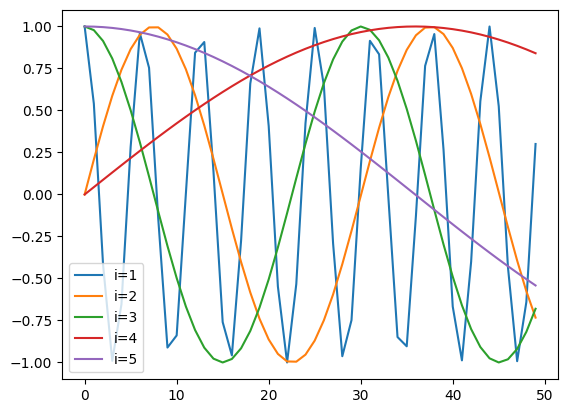

In [1]:
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

matplotlib.font_manager.fontManager.addfont("NotoEmoji-Medium.ttf")

L = 50
d_e = 5
x = np.arange(L)
for i in range(1, 1 + d_e):
    if i % 2 == 0:
        w_p = np.sin(x / L ** (i / d_e))
    else:
        w_p = np.cos(x / L ** ((i - 1) / d_e))
    _ = plt.plot(x, w_p, label=f"i={i}")
plt.legend()

というわけで、この埋めこみは各成分ごとに異なる周波数での単語を埋め込むようです。これにより、短いコンテキストの中での位置も同時に考慮できるのかな。

# Attention
Transformerの主要な構成要素になるのがAttentionです。Attentionでは、入力されたトークン列中のすべてのトークンの組み合わせについて、そいつらの組み合わせがどれくらい重要なのかというモデル化を行います。具体的に、単一クエリに対するAttentionでは、現在のトークンから得た埋め込み$e_t$と$x$中のすべてのトークンの埋め込み$e_0, e_1, ..., e_{Nv} \in E$に対し、以下のような操作を行います。
$$
\begin{align*}
q_t &\leftarrow W_q e_t + b_q \\
k_{t'} &\leftarrow W_k e_{t'} + b_k,~\forall e_{t'} \in E \\
v_{t'} &\leftarrow W_v e_{t'} + b_v,~\forall e_{t'} \in E \\
\alpha_{t'} &\leftarrow \frac{\exp(q_t^\top k_{t'} / \sqrt{d_{\textrm{attn}}})}{\sum_u \exp(q_t^\top k_{t'} / \sqrt{d_{\textrm{attn}}})},~\forall e_{t'} \in E \\
v_\textrm{attr} &\leftarrow \sum_{t = 1}^T \alpha_{t'} v_{t'}
\end{align*}
$$
埋め込みの次元を$d_\textrm{in}$、出力の次元と$d_\textrm{out}$とすると、$W_q, Q_k$は$d_\textrm{attn} \times e$の行列、$W_q, Q_k$は$d_\textrm{out} \times d_\textrm{in}$の行列、$b_*$はベクトル（バイアス項）です。ここで、$q^\top k_{t'}$の値でソフトマックスをとって$v$にマスクをかけるので、これは現在のトークンと$t'$番目のトークンが「どれくらい対応しているか」を表していてほしいです。$v_{t'}$が何を表しているかはタスクによって異なると思いますが、$t'$番目のトークンの埋め込みに線形に関係する値が入っているはずです。このトークン列に後ろ向きの因果関係がない場合（あるトークン$x[t]$が、任意の未来のトークン$x[t']~\textrm{where}~t < t'$に依存しない場合）は、$\alpha_{t'}$にマスクをかける($\alpha_{t'}[i] = 0 ~\textrm{if}~t < i$)こともあります。なので、未来を予測する際にはこのマスクをかけるのが一般的なようです。

実際に、時系列から何か（次の単語、ラベルなど）を予測する際には、この単一クエリに対するAttentionを長さ$T$の系列内のすべてのトークンに対して計算し、$d_\textrm{out} \times T$の行列$\tilde{V}$を得ます。

# やってみよう

とりあえずこれを学習させてみましょう。今回は[jax](https://jax.readthedocs.io/en/latest/)と[equinox](https://docs.kidger.site/equinox/)を使ってモデルを書いてみます。

In [2]:
import equinox as eqx
import jax
import jax.numpy as jnp


class Attention(eqx.Module):
    w_q: jax.Array
    b_q: jax.Array
    w_k: jax.Array
    b_k: jax.Array
    w_v: jax.Array
    b_v: jax.Array
    sqrt_d_attn: float

    def __init__(self, d_in: int, d_attn: int, d_out: int, key: jax.Array) -> None:
        wq_key, bq_key, wk_key, bk_key, wv_key, bv_key = jax.random.split(key, 6)
        self.w_q = jax.random.normal(wq_key, (d_attn, d_in))
        self.b_q = jax.random.normal(bq_key, (d_attn, 1))
        self.w_k = jax.random.normal(wk_key, (d_attn, d_in))
        self.b_k = jax.random.normal(bk_key, (d_attn, 1))
        self.w_v = jax.random.normal(wv_key, (d_out, d_in))
        self.b_v = jax.random.normal(bv_key, (d_out, 1))
        self.sqrt_d_attn = float(np.sqrt(d_attn))

    def __call__(self, e: jax.Array) -> jax.Array:
        """Take a matrix e with shape [d_in x seq_len], compute attention for all tokens in e.
        Outputs a matrix with shape [d_out x seq_len]
        """
        q = self.w_q @ e + self.b_q
        k = self.w_k @ e + self.b_k
        v = self.w_v @ e + self.b_v
        alpha = jax.nn.softmax(q.T @ k / self.sqrt_d_attn, axis=-1)
        return v @ alpha.T


def causal_mask(x: jax.Array, fill: jax.Array = -jnp.inf) -> jax.Array:
    ltri = jnp.tri(x.shape[0], dtype=bool, k=-1)
    return jax.lax.select(ltri, jnp.ones_like(x) * fill, x)


class MaskedAttention(Attention):
    def __call__(self, e: jax.Array) -> jax.Array:
        q = self.w_q @ e + self.b_q
        k = self.w_k @ e + self.b_k
        v = self.w_v @ e + self.b_v
        score = causal_mask(q.T @ k) / self.sqrt_d_attn
        alpha = jax.nn.softmax(score, axis=-1)
        return v @ alpha.T

これを学習させてみましょう。トークンとして、天気🌧️・☁️・☀️を考えます。この3つの記号に対し適当な埋め込みを与えて、次の日の天気を学習させてみます。一般的にTransformerで用いられる方法とは全く違いますが、なるべく簡単なネットワークで学習できるように、以下のような要素数4のベクトルを埋め込みとします。
- $e[0]$: 天気が🌧️なら1、それ以外のときは0
- $e[1]$: 天気が☁️なら同上
- $e[2]$: 天気が☀️なら同上
- $e[3]$: $t/L$(位置埋め込み)

最大文字列長は20にします。

In [3]:
WEATHERS = ["🌧️", "☁️", "☀️"]
MAX_SEQ_LEN = 20

def get_embedding(seq: str) -> np.ndarray:
    length = len(seq) // 2
    e = np.zeros((4, length))
    for i in range(length):
        w = seq[i * 2: i * 2 + 2]
        e[WEATHERS.index(w), i] = 1.0
        e[3, i] = (i + 1) / MAX_SEQ_LEN
    return e

## マルコフモデルの学習

まず簡単なモデルで天気を生成してみます。**次の日の天気は、前の日の天気にもとづいて確率的に決まる**ことにしましょう。🌧️・☁️・☀️がマルチバイト文字であることに注意して、以下のように実装します。

In [89]:
import dataclasses

_GEN = np.random.Generator(np.random.PCG64(20230508))
_MARKOV = {
    "": [0.3, 0.4, 0.3],
    "🌧️": [0.6, 0.3, 0.1],
    "☁️": [0.3, 0.4, 0.3],
    "☀️": [0.2, 0.3, 0.5],
}

def markov(prev: str) -> str:
    prob = _MARKOV[prev[-2:]]
    return prev + _GEN.choice(WEATHERS, p=prob)


def generate(f, n: int):
    value = ""
    for _ in range(n):
        value = f(value)
    return value


@dataclasses.dataclass
class Dataset:
    weathers: list[str]
    embeddings: jax.Array
    next_weather_indices: jax.Array
    
    def __len__(self) -> int:
        return len(self.weathers)


def make_dataset(f, seq_len, size) -> Dataset:
    w_list, e_list, nw_list = [], [], []
    for _ in range(size):
        weathers = generate(f, seq_len + 1)
        e = jnp.array(get_embedding(weathers[:-2]))
        w_list.append(weathers)
        e_list.append(e)
        nw_list.append(WEATHERS.index(weathers[-2:]))
    return Dataset(w_list, jnp.stack(e_list), jnp.array(nw_list))


generated = generate(markov, 10)
generated, get_embedding(generated)

('🌧️🌧️🌧️☀️🌧️☁️🌧️🌧️☀️☀️',
 array([[1.  , 1.  , 1.  , 0.  , 1.  , 0.  , 1.  , 1.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  ],
        [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]]))

こんな感じです。いま、次の日の天気だけ予測したいので、モデルの出力は集合{🌧️・☁️・☀️}上での確率分布が適切でしょう。Attentionは長さ$T$の埋め込み列に対して長さ$d_\textrm{out} \times T$の行列をかえします。なので、$d_\textrm{out} = 3$とし、Attentionの出力$\tilde{V}$に対してソフトマックス関数を適用し、$P_t = \textrm{softmax}(\tilde{V}[:, t])$とします。このとき、$P_t$の各要素が次の日🌧️・☁️・☀️になる確率を表すとして、モデル化します。これを、対数尤度の和$\sum_t \log P_t(\textrm{next weather})$を最大化するように学習しましょう。学習のコードを定義します。

In [60]:
from typing import Callable

import optax


def attn_neglogp(model: eqx.Module, seq: jax.Array, next_w: jax.Array) -> jax.Array:
    batch_size = seq.shape[0]
    tilde_v = jax.vmap(model)(seq)  # B x OUT x SEQ_LEN
    logp = jax.nn.log_softmax(tilde_v, axis=1)  # B x OUT x SEQ_LEN
    logp_masked = logp * jax.nn.one_hot(next_w, num_classes=3).reshape(-1, 3, 1)
    return -jnp.mean(jnp.sum(logp_masked.reshape(batch_size, -1), axis=-1))

def train(
    n_total_epochs: int,
    minibatch_size: int,
    model: eqx.Module,
    ds: Dataset,
    test_ds: Dataset,
    key: jax.Array,
    learning_rate: float = 1e-2,
    loss_fn: Callable[[eqx.Module, jax.Array, jax.Array], jax.Array] = attn_neglogp,
) -> tuple[eqx.Module, jax.Array, list[float], list[float]]:
    n_data = len(ds)
    optim = optax.adam(learning_rate)

    @eqx.filter_jit
    def train_1step(
        model: eqx.Module,
        seq: jax.Array,
        next_w: jax.Array,
        opt_state: optax.OptState,
    ) -> tuple[jax.Array, eqx.Module, optax.OptState]:
        loss, grads = eqx.filter_value_and_grad(loss_fn)(model, seq, next_w)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    opt_state = optim.init(model)
    n_optim_epochs = n_data // minibatch_size
    loss_list, eval_list = [], []
    for epoch in range(n_total_epochs // n_optim_epochs):
        key, perm_key = jax.random.split(key)
        indices = jax.random.permutation(perm_key, n_data, independent=True)
        for _ in range(n_optim_epochs):
            e = ds.embeddings[indices]
            next_w = ds.next_weather_indices[indices]
            loss, model, opt_state = train_1step(model, e, next_w, opt_state)
            loss_list.append(loss.item())
            test_loss = jax.jit(loss_fn)(
                model,
                test_ds.embeddings,
                test_ds.next_weather_indices,
            )
            eval_list.append(test_loss.item())
    return model, key, loss_list, eval_list

これを実際に走らせてみます。適当に、Attentionの次元を8、天気列の長さを10にしましょう。

'Accuracy: 0.46700000762939453'

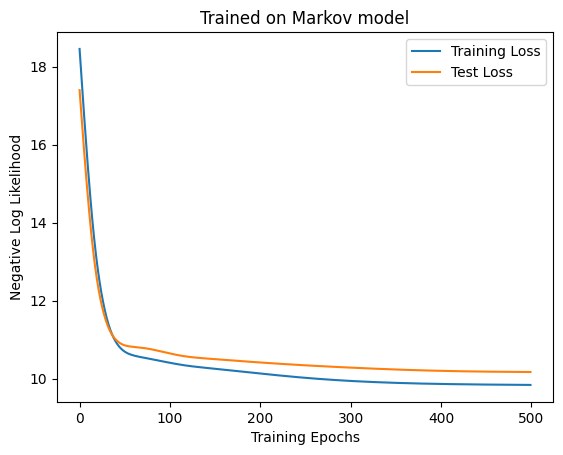

In [112]:
D_ATTN = 8
SEQ_LEN = 10
key = jax.random.PRNGKey(1234)
model = MaskedAttention(4, D_ATTN, 3, key)
ds = make_dataset(markov, SEQ_LEN, 1000)
test_ds = make_dataset(markov, SEQ_LEN, 1000)
model, key, loss_list, eval_list = train(500, 100, model, ds, test_ds, key, 1e-2)
plt.plot(loss_list, label="Training Loss")
plt.plot(eval_list, label="Test Loss")
plt.title("Trained on Markov model")
plt.xlabel("Training Epochs")
plt.ylabel("Negative Log Likelihood")
plt.legend()

@jax.jit
def accuracy(model: eqx.Module, seq: jax.Array, next_w: jax.Array) -> float:
    tilde_v = jax.vmap(model)(seq)  # B x OUT x SEQ_LEN
    inferred = jnp.argmax(tilde_v[:, :, 0], axis=1)
    n_correct = jnp.sum(inferred == next_w)
    return n_correct / seq.shape[0]

f"Accuracy: {accuracy(model, test_ds.embeddings, test_ds.next_weather_indices).item()}"

400エポックあたりでロスが落ちなくなっているので収束はしていそうです。実際に何を学習したのか確認してみましょう。とりあえず天気を生成してみます。まあこんなもの見ても何もわからないのですが、生成の流れを確認しておくにはいいかなと。ビームサーチが使われることが多いようですが、面倒なので今回はもっと簡単な方法を使います。☁️からスタートして、カテゴリカル分布から次の天気をサンプルし、どんどん足していくことにします。

In [113]:
def generate_from_model(
    model: eqx.Module,
    key: jax.Array,
    seq_len: int,
    init: str = "☁️",
) -> tuple[str, jax.Array]:
    @jax.jit
    def step(
        model: eqx.Module,
        seq: jax.Array,
        key: jax.Array,
    ) -> tuple[jax.Array, jax.Array]:
        sample_key, key = jax.random.split(key)
        tilde_v = model(seq)  # 3 x len(seq)
        sampled = jax.random.categorical(key=sample_key, logits=tilde_v[:, 0])
        return sampled, key

    generated = init
    for _ in range(seq_len):
        e = get_embedding(generated)
        next_w, key = step(model, get_embedding(generated), key)
        generated += WEATHERS[next_w.item()]
    return generated, key


generated, key = generate_from_model(model, key, 20)
generated

'☁️🌧️🌧️☀️🌧️☁️🌧️☀️☀️☀️☀️☁️☀️☀️☀️☀️☀️☁️☁️☀️☁️'

こんな感じになりました。当たり前ですがこれを見たところで何もわからないですね。次に、テストデータ中の適当なデータに対しAttentionの中身を可視化してみます。

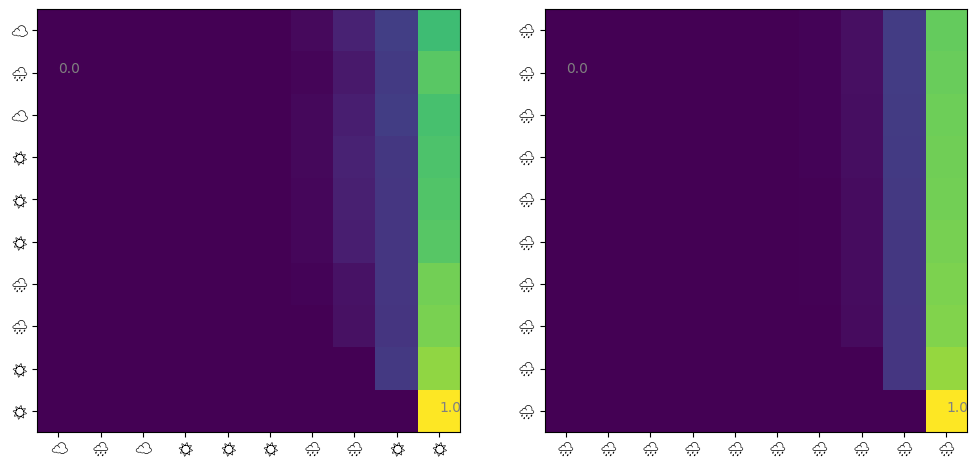

In [114]:
@jax.jit
def get_attn(model: eqx.Module, seq: jax.Array) -> jax.Array:
    q = model.w_q @ seq + model.b_q
    k = model.w_k @ seq + model.b_k
    score = causal_mask(q.T @ k) / model.sqrt_d_attn
    return jax.nn.softmax(score, axis=-1)


def visualize_attn(ax, model: eqx.Module, ds: Dataset, index: int = 0) -> None:
    attn = np.array(get_attn(model, ds.embeddings[index]))
    im = ax.imshow(attn)
    ax.set_xticks(
        np.arange(10),
        labels=[ds.weathers[index][i * 2] for i in range(10)],
        fontname="Noto Emoji",
    )
    ax.set_yticks(
        np.arange(10),
        labels=[ds.weathers[index][i * 2] for i in range(10)],
        fontname="Noto Emoji",
    )
    for i in [np.argmin(attn), np.argmax(attn)]:
        # Show min and max values
        im.axes.text(i % 10, i // 10, f"{attn.flatten()[i]:.1f}", color="gray")


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
visualize_attn(ax1, model, test_ds, 1)
visualize_attn(ax2, model, test_ds, 2)

matplotlibでカラー絵文字が使えなかったのでモノクロの絵文字にしました。というわけで、
1. 直前の天気→直前の天気 のAttentionが最も大きい
2. 他の日の天気→直前の天気 のAttentionも大きい
3. 他はほとんど関係ない

といったことがわかります。マルコフモデルから生成した天気列を学習させたので、1は当たり前ですよね。2の他の日の天気→直前の天気の関係も実際はいらないのですが、注意されているようです。

## 独立に発生した過去の複数の事象に依存して将来の出来事が決まる場合
次に、もう少し複雑なデータを学習させてみましょう。今度は、以下のような方法で11日ぶんの天気を生成します。
1. 1日目、4日目、8日目の天気を独立に生成する
2. 2,3日目の天気を1日目の天気を初期状態とするマルコフ連鎖により生成する。5,6,7,9,10日目の天気についても、4日目・8日目の天気にもとづいて同様に生成する。
3. 11日目の天気を1日目、4日目、8日目の天気から確率的に生成する。

これを学習できるか試してみましょう。

In [115]:
def _make_table() -> dict[str, list[float]]:
    candidates = []
    for i in range(1, 9):
        for j in range(1, 9):
            for k in range(1, 9):
                if i + j + k == 10:
                    candidates.append((i, j, k))
    table = {}
    for i in WEATHERS:
        for j in WEATHERS:
            for k in WEATHERS:
                table[i + j + k] = [p / 10 for p in _GEN.choice(candidates)]
    return table

_ONE_FOUR_8_TABLE = _make_table()

def one_four_8(prev: str) -> str:
    length = len(prev) // 2
    if length == 10:
        p = _ONE_FOUR_8_TABLE[prev[0: 2] + prev[6: 8] + prev[14: 16]]
        return prev + _GEN.choice(WEATHERS, p=p)
    elif length == 4 or length == 8:
        return prev + _GEN.choice(WEATHERS, p=_MARKOV[""])
    else:
        return markov(prev)
    
generate(one_four_8, 11)

'☁️☁️☁️☀️🌧️🌧️☁️☁️☁️☁️☁️'

こんな感じですね。では学習させましょう。さっきよりも少しデータが複雑なので、サンプルの数を増やしてみます。

'Accuracy: 0.34800001978874207'

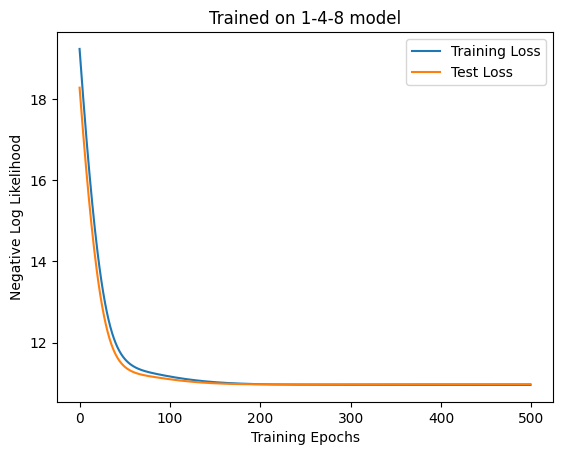

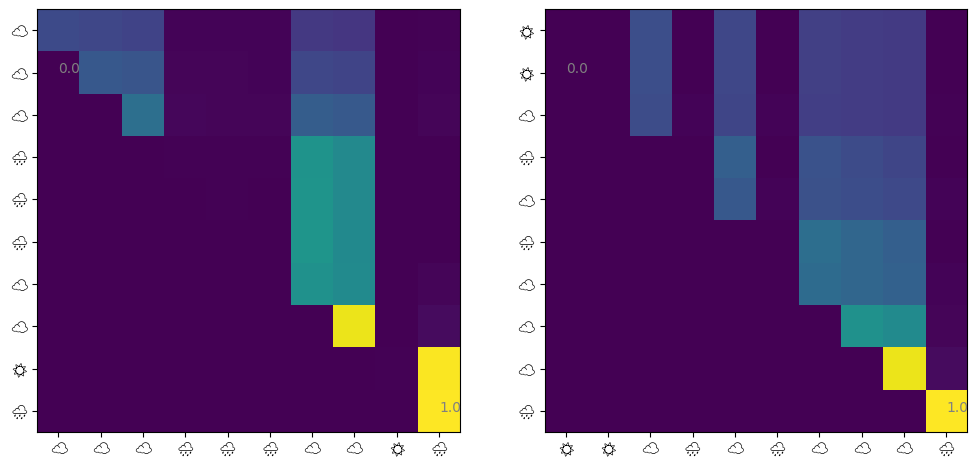

In [116]:
D_ATTN = 8
SEQ_LEN = 10
model = MaskedAttention(4, D_ATTN, 3, key)
ds = make_dataset(one_four_8, SEQ_LEN, 1000)
test_ds = make_dataset(one_four_8, SEQ_LEN, 1000)
model, key, loss_list, eval_list = train(500, 100, model, ds, test_ds, key, 1e-2)
plt.plot(loss_list, label="Training Loss")
plt.plot(eval_list, label="Test Loss")
plt.title("Trained on 1-4-8 model")
plt.xlabel("Training Epochs")
plt.ylabel("Negative Log Likelihood")
plt.legend()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
visualize_attn(ax1, model, test_ds, 1)
visualize_attn(ax2, model, test_ds, 2)

f"Accuracy: {accuracy(model, test_ds.embeddings, test_ds.next_weather_indices).item()}"

損失は小さくなっていますがAccuracyが悪くまたAttentionの出方も微妙ですね。一応1・4・8日目にも注意がいっていますが、先ほどの実験と同じく最後の日の注意が大きめに出ていますね。

## Attentionいらないんじゃ...
勘のいい読者の方はお気づきかと思いますが、ここまで学習させた2つの天気列を表現するのに、Attentionなんて小難しいものはいらないですよね。最初のものは前日（10日目)の天気、次のやつは1・4・8日目から11日目の天気が決定されるため、入力された天気列の内部相関がタスクに一切関係ないからです。というわけで、線形モデル+ソフトマックス(いわゆるmultinomial logistic regressionというやつ)で学習してみましょう。

'Accuracy: 0.48500001430511475'

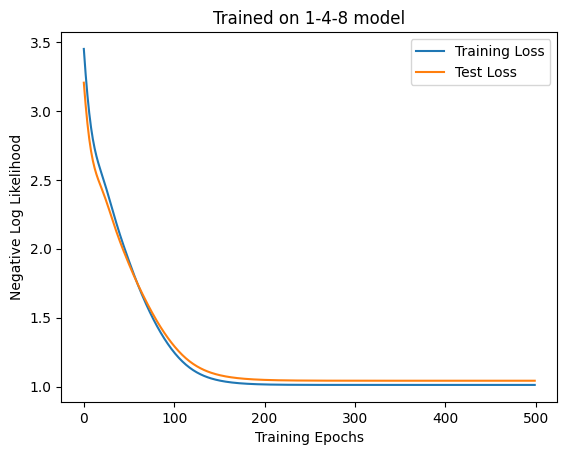

In [117]:
class LinearModel(eqx.Module):
    w: jax.Array
    b: jax.Array

    def __init__(self, d_in: int, d_out: int, key: jax.Array) -> None:
        w_key, b_key = jax.random.split(key)
        self.w = jax.random.normal(w_key, (d_out, d_in))
        self.b = jax.random.normal(b_key, (d_out,))

    def __call__(self, seq: jax.Array) -> jax.Array:
        return self.w @ seq.flatten() + self.b


def linear_neglogp(model: eqx.Module, seq: jax.Array, next_w: jax.Array) -> jax.Array:
    batch_size = seq.shape[0]
    logp = jax.nn.log_softmax(jax.vmap(model)(seq), axis=1)  # B x OUT
    logp_masked = logp * jax.nn.one_hot(next_w, num_classes=3)
    return -jnp.mean(jnp.sum(logp_masked, axis=1))


model = LinearModel(4 * SEQ_LEN, 3, key)
model, key, loss_list, eval_list = train(
    500, 100, model, ds, test_ds, key, 1e-2, linear_neglogp
)
plt.plot(loss_list, label="Training Loss")
plt.plot(eval_list, label="Test Loss")
plt.title("Trained on 1-4-8 model")
plt.xlabel("Training Epochs")
plt.ylabel("Negative Log Likelihood")
plt.legend()


@jax.jit
def linear_accuracy(model: eqx.Module, seq: jax.Array, next_w: jax.Array) -> float:
    tilde_v = jax.vmap(model)(seq)  # B x OUT
    inferred = jnp.argmax(tilde_v, axis=1)
    n_correct = jnp.sum(inferred == next_w)
    return n_correct / seq.shape[0]


f"Accuracy: {linear_accuracy(model, test_ds.embeddings, test_ds.next_weather_indices).item()}"

普通にこっちのほうが良さそうですね...。では、Attentionはどういう時に役に立つのでしょうか。

1. パラメータ数がをトークン列の長さ$L$に依存させたくないとき

Attentionではパラメータの数が $(d_\textrm{in} + 1)(2d_\textrm{attn} + d_\textrm{out})$になるのに対し、線形モデルでは$(d_\textrm{in}L + 1)d_\textrm{out}$になることに注意しましょう。また、線形モデルでは任意の長さの系列を扱うことはできません。

2. トークン列の内部相関があるとき

トークン列よりもっと一般化して、確率的なイベントの集合$A, B, C$が与えられたときに$D$を予測する問題を考えます。このとき、予測したい確率分布は$P(D|A, B, C)$になります。イベント$A, B, C$の間に因果関係が存在しないとき、この問題はこれ以上簡単になりません。一方で、つまり、$D$の条件付き確率分布は独立な事象$A, B, C$


## 